<a href="https://colab.research.google.com/github/Dltmd202/DeepLearningStudy/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
np.random.seed(42)

(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)
word_to_index = imdb.get_word_index()

for i in range(len(x_train_all)):
  x_train_all[i] = [w for w in x_train_all[i] if w > 2]

random_index = np.random.permutation(25000)
x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)


17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


1646592/1641221 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [20]:
class RecurrentNetwork:
  def __init__(self, n_cells=10, batch_size=32, learning_rate=0.1):
    self.n_cells = n_cells
    self.batch_size = batch_size
    self.w1h = None
    self.w1x = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.h = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
  
  def forpass(self, x):
    self.h = [np.zeros((x.shape[0], self.n_cells))]

    seq = np.swapaxes(x, 0, 1)
    for x in seq:
      z1 = np.dot(x, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1
      h = np.tanh(z1)
      self.h.append(h)
      z2 = np.dot(h, self.w2) + self.b2
    return z2
  
  def backprop(self, x, err):
    m = len(x)

    w2_grad = np.dot(self.h[-1].T, err) / m
    b2_grad = np.sum(err) / m
    seq = np.swapaxes(x, 0, 1)
    w1h_grad = w1x_grad = b1_grad = 0
    err_to_cell = np.dot(err, self.w2.T) * (1 - self.h[-1] ** 2)
    for x, h in zip(seq[::-1][:10], self.h[:-1][::-1][:10]):
      w1h_grad += np.dot(h.T, err_to_cell)
      w1x_grad += np.dot(x.T, err_to_cell)
      b1_grad += np.sum(err_to_cell, axis=0)
      err_to_cell = np.dot(err_to_cell, self.w1h) * (1 - h ** 2)
    
    w1h_grad /= m
    w1x_grad /= m
    b1_grad /= m

    return w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad
  
  def sigmoid(self, z):
    a = 1 /(1 + np.exp(-z))
    return a
  
  def init_weights(self, n_features, n_classes):
    orth_init = tf.initializers.Orthogonal()
    glorot_init = tf.initializers.GlorotUniform()

    self.w1h = orth_init((self.n_cells, self.n_cells)).numpy()
    self.w1x = glorot_init((n_features, self.n_cells)).numpy()
    self.b1 = np.zeros(self.n_cells)
    self.w2 = glorot_init((self.n_cells, n_classes)).numpy()
    self.b2 = np.zeros(n_classes)

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    np.random.seed(42)
    self.init_weights(x.shape[2], y.shape[1])
    for i in range(epochs):
      print('에포크', i, end=' ')
      batch_losses = []
      for x_batch, y_batch in self.gen_batch(x, y):
        print('.', end='')
        a = self.training(x_batch, y_batch)
        a = np.clip(a, 1e-10, 1-1e-10)
        loss = np.mean(-(y_batch*np.log(a) + (1 - y_batch)*np.log(1-a)))
        batch_losses.append(loss)
      print()
      self.losses.append(np.mean(batch_losses))
      self.update_val_loss(x_val, y_val)
  
  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size
    if length %  self.batch_size:
      bins += 1
    indexes = np.random.permutation(np.arange(len(x)))
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]
  
  def training(self, x, y):
     m = len(x)
     z = self.forpass(x)
     a = self.sigmoid(z)
     err = -(y - a)
     w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
     self.w1h -= self.lr * w1h_grad
     self.w1x -= self.lr * w1x_grad
     self.b1 -= self.lr * b1_grad
     self.w2 -= self.lr * w2_grad
     self.b2 -= self.lr * b2_grad
     return a
    
  def predict(self, x):
    z = self.forpass(x)
    return z > 0
  
  def score(self, x, y):
    return np.mean(self.predict(x) == y.reshape(1, -1))
  
  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.sigmoid(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss = np.mean(-(y_val*np.log(a)+ (1-y_val)*np.log(1-a)))
    self.val_losses.append(val_loss)

In [21]:
rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=0.01)
rn.fit(x_train_onehot, y_train, epochs=20, x_val=x_val_onehot, y_val=y_val)

에포크 0 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 ..........................................................................................................................................................................................................................................................................................................................................................................

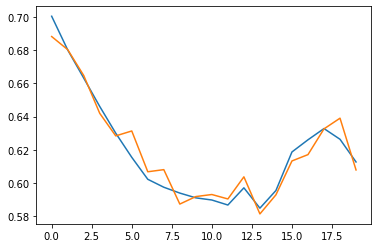

In [22]:
import matplotlib.pyplot as plt

plt.plot(rn.losses)
plt.plot(rn.val_losses)
plt.show()

In [23]:
rn.score(x_val_onehot, y_val)

0.49828848